In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
import pickle
import spacy
import ast

import pyLDAvis
import pyLDAvis.gensim  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)



import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to C:\Users\Devdatta
[nltk_data]     Supnekar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Devdatta
[nltk_data]     Supnekar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv("bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
stop_words = stopwords.words('english')
file = open("stopwords/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()
file = open("stopwords/contractions.txt", "r")
contractions = ast.literal_eval(file.read())
file.close()

In [4]:
print(df.category.unique())

['tech' 'business' 'sport' 'entertainment' 'politics']


In [5]:
# Convert to list
data = df.text.values.tolist()
print(len(data))

2225


In [6]:
for i in data[0]:
    print(i)

t
v
 
f
u
t
u
r
e
 
i
n
 
t
h
e
 
h
a
n
d
s
 
o
f
 
v
i
e
w
e
r
s
 
w
i
t
h
 
h
o
m
e
 
t
h
e
a
t
r
e
 
s
y
s
t
e
m
s
 
 
p
l
a
s
m
a
 
h
i
g
h
-
d
e
f
i
n
i
t
i
o
n
 
t
v
s
 
 
a
n
d
 
d
i
g
i
t
a
l
 
v
i
d
e
o
 
r
e
c
o
r
d
e
r
s
 
m
o
v
i
n
g
 
i
n
t
o
 
t
h
e
 
l
i
v
i
n
g
 
r
o
o
m
 
 
t
h
e
 
w
a
y
 
p
e
o
p
l
e
 
w
a
t
c
h
 
t
v
 
w
i
l
l
 
b
e
 
r
a
d
i
c
a
l
l
y
 
d
i
f
f
e
r
e
n
t
 
i
n
 
f
i
v
e
 
y
e
a
r
s
 
 
t
i
m
e
.
 
 
t
h
a
t
 
i
s
 
a
c
c
o
r
d
i
n
g
 
t
o
 
a
n
 
e
x
p
e
r
t
 
p
a
n
e
l
 
w
h
i
c
h
 
g
a
t
h
e
r
e
d
 
a
t
 
t
h
e
 
a
n
n
u
a
l
 
c
o
n
s
u
m
e
r
 
e
l
e
c
t
r
o
n
i
c
s
 
s
h
o
w
 
i
n
 
l
a
s
 
v
e
g
a
s
 
t
o
 
d
i
s
c
u
s
s
 
h
o
w
 
t
h
e
s
e
 
n
e
w
 
t
e
c
h
n
o
l
o
g
i
e
s
 
w
i
l
l
 
i
m
p
a
c
t
 
o
n
e
 
o
f
 
o
u
r
 
f
a
v
o
u
r
i
t
e
 
p
a
s
t
i
m
e
s
.
 
w
i
t
h
 
t
h
e
 
u
s
 
l
e
a
d
i
n
g
 
t
h
e
 
t
r
e
n
d
 
 
p
r
o
g
r
a
m
m
e
s
 
a
n
d
 
o
t
h
e
r
 
c
o
n
t
e
n
t
 
w
i
l
l
 
b
e
 
d
e
l
i
v
e
r
e
d
 
t
o
 
v
i
e
w
e
r
s
 
v
i
a
 
h


In [7]:

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[0])

('tv future in the hands of viewers with home theatre systems plasma '
 'high-definition tvs and digital video recorders moving into the living room '
 'the way people watch tv will be radically different in five years time. that '
 'is according to an expert panel which gathered at the annual consumer '
 'electronics show in las vegas to discuss how these new technologies will '
 'impact one of our favourite pastimes. with the us leading the trend '
 'programmes and other content will be delivered to viewers via home networks '
 'through cable satellite telecoms companies and broadband service providers '
 'to front rooms and portable devices. one of the most talked-about '
 'technologies of ces has been digital and personal video recorders (dvr and '
 'pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow '
 'people to record store play pause and forward wind tv programmes when they '
 'want. essentially the technology allows for much more personalised tv. they 

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[0])


['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# See bigram example
print(bigram_mod[data_words[0]])


['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high_definition', 'tvs', 'and', 'digital', 'video_recorders', 'moving', 'into', 'the', 'living_room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer_electronics', 'show', 'in', 'las_vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service_providers', 'to', 'front', 'rooms', 'and', 'portable_devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has', 'been', 'digital',

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [72]:
print(len(data_lemmatized))

2225


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 7), (12, 2), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 2), (21, 1), (22, 2), (23, 1), (24, 5), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 4), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 4), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 2), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 2), (72, 3), (73, 1), (74, 1), (75, 3), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 3), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 2), (107, 1), (108, 1), (109, 1), (110, 5),

In [16]:
id2word[0]

'abide'

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abide', 1),
  ('adam', 1),
  ('advert', 1),
  ('advertising', 2),
  ('announce', 1),
  ('annual', 1),
  ('bbc', 2),
  ('big', 2),
  ('bill_gate', 1),
  ('book', 1),
  ('box', 1),
  ('brand', 7),
  ('broadband', 2),
  ('broadcast', 1),
  ('broadcaster', 1),
  ('build', 2),
  ('business', 1),
  ('button', 1),
  ('cable', 2),
  ('call', 1),
  ('capability', 2),
  ('carte', 1),
  ('ce', 2),
  ('challenge', 1),
  ('channel', 5),
  ('chief', 1),
  ('choice', 2),
  ('comfortable', 1),
  ('commercial', 1),
  ('communication', 1),
  ('company', 3),
  ('concern', 1),
  ('connection', 1),
  ('consumer', 1),
  ('consumer_electronic', 1),
  ('content', 4),
  ('control', 1),
  ('crystal', 1),
  ('deliver', 1),
  ('device', 1),
  ('diaper', 1),
  ('digital', 2),
  ('directtv', 1),
  ('discuss', 1),
  ('display', 1),
  ('dvd', 1),
  ('dvr', 4),
  ('enhance', 1),
  ('entertainment', 1),
  ('essentially', 1),
  ('europe', 2),
  ('experience', 1),
  ('expert', 1),
  ('external', 1),
  ('familiar', 1)

In [56]:
def tune_model(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                        minimum_probability=0.0)
#                                            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(round(coherencemodel.get_coherence(),3))

    return model_list, coherence_values

In [57]:
gensim.models.ldamodel.LdaModel?

In [58]:
# Can take a long time to run
model_list, coherence_values = tune_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:05<00:00, 60.92s/it]


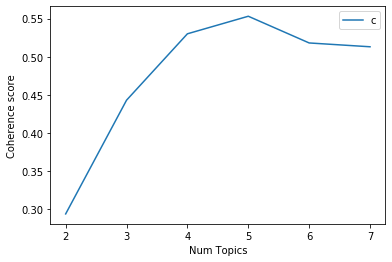

In [59]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [60]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.294
Num Topics = 3  has Coherence Value of 0.443
Num Topics = 4  has Coherence Value of 0.53
Num Topics = 5  has Coherence Value of 0.553
Num Topics = 6  has Coherence Value of 0.518
Num Topics = 7  has Coherence Value of 0.513


In [61]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.016*"film" + 0.008*"year" + 0.008*"tv" + 0.008*"award" + 0.007*"mobile" + '
  '0.007*"music" + 0.006*"people" + 0.006*"include" + 0.006*"time" + '
  '0.006*"technology"'),
 (1,
  '0.010*"year" + 0.009*"play" + 0.008*"game" + 0.008*"player" + 0.008*"win" + '
  '0.006*"england" + 0.006*"time" + 0.004*"match" + 0.004*"team" + '
  '0.004*"wale"'),
 (2,
  '0.011*"year" + 0.007*"company" + 0.006*"rise" + 0.006*"bank" + '
  '0.005*"report" + 0.005*"market" + 0.005*"firm" + 0.005*"government" + '
  '0.004*"sale" + 0.004*"dollar"'),
 (3,
  '0.011*"party" + 0.010*"labour" + 0.010*"people" + 0.008*"blair" + '
  '0.007*"government" + 0.007*"election" + 0.006*"plan" + 0.005*"public" + '
  '0.005*"tory" + 0.005*"brown"'),
 (4,
  '0.011*"people" + 0.007*"firm" + 0.007*"user" + 0.006*"technology" + '
  '0.006*"site" + 0.006*"phone" + 0.006*"game" + 0.006*"computer" + '
  '0.006*"information" + 0.005*"year"')]


In [63]:
x = optimal_model.show_topics(num_topics=5, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(str(topic) + "::" + str(words))
print()

print("---------------------")

0::['film', 'year', 'tv', 'award', 'mobile', 'music', 'people', 'include', 'time', 'technology']
1::['year', 'play', 'game', 'player', 'win', 'england', 'time', 'match', 'team', 'wale']
2::['year', 'company', 'rise', 'bank', 'report', 'market', 'firm', 'government', 'sale', 'dollar']
3::['party', 'labour', 'people', 'blair', 'government', 'election', 'plan', 'public', 'tory', 'brown']
4::['people', 'firm', 'user', 'technology', 'site', 'phone', 'game', 'computer', 'information', 'year']

---------------------


In [64]:
import operator
from functools import reduce
from collections import defaultdict

In [65]:
def _document_topic_matrix(model, doc_term_matrix):

    a = reduce(operator.concat, model[doc_term_matrix])
    d = defaultdict(list)
    for tup in a:
        d[tup[0]] += (tup[1],)
    df = pd.DataFrame.from_dict(d)
    doc_topic_matrix = df.values
    return doc_topic_matrix

In [66]:
a = _document_topic_matrix(optimal_model, corpus)

In [69]:
a[0]

array([7.29823589e-01, 2.64983857e-04, 4.20071185e-02, 1.96558074e-04,
       2.27707759e-01])

In [67]:
a

array([[7.29823589e-01, 2.64983857e-04, 4.20071185e-02, 1.96558074e-04,
        2.27707759e-01],
       [1.44272342e-01, 5.78659063e-04, 8.54389071e-01, 4.29230480e-04,
        3.30753624e-04],
       [5.60667482e-04, 8.78231466e-01, 8.57159146e-04, 1.19878829e-01,
        4.71864099e-04],
       ...,
       [4.10759181e-04, 9.98166919e-01, 6.27973117e-04, 4.48626262e-04,
        3.45699576e-04],
       [1.81381052e-04, 2.67060910e-04, 2.77296291e-04, 9.99121547e-01,
        1.52652356e-04],
       [7.76813133e-04, 9.96533394e-01, 1.18758716e-03, 8.48426076e-04,
        6.53774769e-04]])

In [70]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        print(row)
        break
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

final_df = df_dominant_topic.drop("Document_No", axis=1)

# add clean text Show
clean_text = [ " ".join(i) for i in texts]
final_df["Clean_Text"] = clean_text

# show
final_df.head(10)

[(0, 0.72984475), (1, 0.0002649839), (2, 0.041959174), (3, 0.00019655809), (4, 0.22773452)]


ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
final_df["Topic_No"].value_counts()

In [46]:
final_df.columns

Index(['Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text',
       'Clean_Text'],
      dtype='object')

# Classification 

In [43]:
from gensim.models import Word2Vec  
from sklearn.feature_extraction.text import TfidfVectorizer   
import pickle
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [50]:
# Classification using TFIDF vectorizer

# Vectorize training and testing data. Here we would pass TfidfVectorizer() to vec 
def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    print('Vectorization complete.\n')
    
    
    return X_train_vec, X_test_vec


In [45]:
# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    
    return

In [47]:
## Preparing to make a pipeline 
models = {
    'Naive Bayes': MultinomialNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
#     'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()   ## This model would take a little longer to run 
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] }, 
    'Decision Tree': { 'min_samples_split': [1, 2, 5] }, 
#     'Perceptron': { 'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'learning_rate': [0.05, 0.1], 'min_samples_split': [2, 5] }
}


# Encode label categories to numbers
enc = LabelEncoder()
final_df['Topic_No'] = enc.fit_transform(final_df['Topic_No'])
labels = list(enc.classes_)

print(labels)

[0.0, 1.0, 2.0, 3.0, 4.0]


In [48]:
# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(final_df['Text'], final_df['Topic_No'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)
## ML_modeling method also prints performance scores for each classifier

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Accuracy: 0.951 	Precision: 0.950 	Recall: 0.949 		F1: 0.949



C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\lib\site-packages\sklearn\tree\_classes.py", line 907, in fit
    X_idx_sorted=X_idx_sorted)
  File "C:\Anaconda\lib\site-packages\sklearn\tree\_classes.py", line 241, in fit
    % self.min_samples_split)
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
 

Decision Tree : {'min_samples_split': 5}
Accuracy: 0.769 	Precision: 0.772 	Recall: 0.770 		F1: 0.769

Gradient Boosting : {'learning_rate': 0.1, 'min_samples_split': 5}
Accuracy: 0.879 	Precision: 0.882 	Recall: 0.881 		F1: 0.880



In [ ]:
with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(final_df['Text'], final_df['Topic_No'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

In [56]:
# Vectorize training and testing data. Here we would pass TfidfVectorizer() to vec 
def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    with open('Vectorizer.pickle', 'wb') as handle:
        pickle.dump(vec, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print('Vectorization complete.\n')
    
    
    return X_train_vec, X_test_vec

def build_model(models, params, X_train, X_test, y_train, y_test):
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    
    # dump model
    with open('model.pickle', 'wb') as handle:
        pickle.dump(gs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Model saved..")
    
    return gs

def clean_input(data):
#     data = re.sub(r"\b" + key + r"\b", value, data.lower())
    data = re.sub("\s+", " ", str(data))
    data = re.sub("\S*@\S*\s?", "", str(data))
    data = re.sub(r"https?://\S+|www\.\S+", "", str(data))
    data = re.sub("(\\d|\\W)+", " ", str(data))
    data = re.sub("'", "", data)
    
    return data

In [57]:
# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(final_df['Clean_Text'], final_df['Topic_No'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

models = {
    'Naive Bayes': MultinomialNB()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] } 
}

model = build_model(models, params, X_train_vec, X_test_vec, y_train, y_test)

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Accuracy: 0.964 	Precision: 0.964 	Recall: 0.963 		F1: 0.963

Model saved..


In [93]:
input_text = """
Computer technology is leading to more accurate sizing and rating methods for process equipment. Heat exchangers are designed with high-precision prediction methods and complex numerical techniques to account for the local flow and temperature conditions. Fouling mitigation is just changing from an art to a science-based technology. The real benefits of sophisticated design codes will not be achieved without reliable fouling prediction methods and mitigation techniques that can be incorporated into the design phase. Recent developments in the computer technology provide an opportunity to productively use fouling information that is scattered in the literature, industry log books, and in reports. A long-term goal for the industry is to develop a knowledge-based system for designing and operating heat exchangers with a minimum impact of water fouling. The major challenges to develop the knowledge-based system are as follows:
Compilation and organization of the fouling data
Easy access by both research organizations and industry
Development of a logic system for interpreting the fouling data
Industrial acceptance of such knowledge-based systems
The fouling data and analyses reported in the literature are often inadequately utilized. To effectively utilize these data, compilation and organization of fouling information are major tasks and challenges for research organizations and industries. This task is more important for the fouling-mitigation technology as compared to other engineering areas. It is hard to imagine that there could be a single correlation with a given set of parameters that can be used to predict the rate of fouling or determine the threshold fouling conditions. One has to rely on the best possible approach to mitigate fouling for a given set of conditions. In the absence of such information, either mitigation methods are overutilized, with high chemical costs, or underutilized, with high maintenance and production costs. Perrakis et al. [54] introduced an approach for compiling the fouling data in the literature. A major cooperative effort is required to carry out such a major challenge for compiling and organizing data. The fouling data and analyses must be accompanied with physical and chemical parameters without which the data have little value.
"""

In [98]:
# load model file
with open('model.pickle', 'rb') as handle:
    NB_model = pickle.load(handle)
    
# load vectorizer file
with open('Vectorizer.pickle', 'rb') as handle:
    vect = pickle.load(handle)

In [111]:
feat =  vect.transform([clean_input(input_text)]).toarray()
pred = NB_model.predict(feat)
pred

array([0], dtype=int64)